# Train random forest model using reflectance data on foliar moisture from a large dataset across NSW

In [ ]:
## Code based on work by ANU-WALD lab, with permission from Marta Yebra
## https://github.com/ANU-WALD/sentinel2_fmc/blob/main/fmc_s2_rf_training.ipynb

### Load modules and define function to load data

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
sns.set_context('paper')

In [1]:
def regplot_stats(data,x,y,x_axname=None,y_axname=None,origin_line=False,outfilep=None,xlims=None,ylims=None,negative=False):
    '''Plots seaborn jointplot with pearsons r and significance, RMSE and MAE, with origin line optional'''
    f,ax = plt.subplots(figsize=(9, 9))
    sns.regplot(ax=ax,x=x,y=y,data=data,ci=None);
    ax.set_xlabel(x_axname);ax.set_ylabel(y_axname)
    if origin_line == True:
        if negative == True:
            ax.plot([1, 0], [0, 1], transform=ax.transAxes, linestyle='--')
        else:
            ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--')
    if xlims != None:
        plt.xlim(xlims);
    if ylims != None:
        plt.ylim(ylims);
    r, p = stats.pearsonr(data[x], data[y]);r2 = round(r**2,3)
    rmse,mae = np.sqrt(mean_squared_error(data[x], data[y])), mean_absolute_error(data[x], data[y])
    if p < 0.01:
        p = '< 0.01'
    phantom, = ax.plot([], [], linestyle="", alpha=0)
    if isinstance(p,str) == True:
        ax.legend([phantom],[f'r\u00b2 = {r2}, p '+p+f', RMSE = {round(rmse,3)}, MAE = {round(mae,3)}'])
    else:
    if isinstance(outfilep,str) == True:
        plt.savefig(outfilep,dpi=1000,bbox_inches='tight')

In [3]:
veg_type_name = {0: "Combined", 1: "Grassland", 2: "Shrubsland", 3: "Forest"}

def generate_train_datasets(veg_type=0, subset_perc=0.15, test_size=0.25):
    # 1.- Load
    df = pd.read_csv("data/reflectances_s2_fmc.csv", index_col=0)
    df.reset_index(drop=True, inplace=True)
    df.dropna(axis='rows',how='any', inplace=True)
    
    df['ndvi'] = ((df.nbart_nir_1-df.nbart_red)/(df.nbart_nir_1+df.nbart_red))
    df['ndii'] = ((df.nbart_nir_1-df.nbart_swir_2)/(df.nbart_nir_1+df.nbart_swir_2))
    
    # 2.- Shuffle
    df = df.sample(frac=1)

    # 3.- Filter veg_type
    if veg_type != 0:
        df = df[df['veg_type']==veg_type]

    # 4.- Subset
    df = df.sample(frac=subset_perc)

    # 5.- Split train/val
    return train_test_split(df, test_size=test_size)

In [4]:
veg_type = 3
train, test = generate_train_datasets(veg_type)
variables = ['ndvi','ndii','nbart_blue','nbart_green','nbart_red','nbart_red_edge_1','nbart_red_edge_2',
             'nbart_red_edge_3','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']

### Random Forest test

In [5]:
# Create a dictionary with different sets of predictors to test in random forest training
var = {'All indices and bands':['ndvi','ndii','nbart_blue','nbart_green','nbart_red','nbart_red_edge_1','nbart_red_edge_2',
             'nbart_red_edge_3','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3'],
       'Only NDII and all bands':['ndii','nbart_blue','nbart_green','nbart_red','nbart_red_edge_1','nbart_red_edge_2',
             'nbart_red_edge_3','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3'],
       'Only NDVI and all bands':['ndvi','nbart_blue','nbart_green','nbart_red','nbart_red_edge_1','nbart_red_edge_2',
             'nbart_red_edge_3','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3'],
       'Only bands':['nbart_blue','nbart_green','nbart_red','nbart_red_edge_1','nbart_red_edge_2',
             'nbart_red_edge_3','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3'],
       'All indices and bands except red edges':['ndvi','ndii','nbart_blue','nbart_green','nbart_red','nbart_nir_1',
                                                'nbart_nir_2','nbart_swir_2','nbart_swir_3'],
       'All indices and bands except green':['ndvi','ndii','nbart_blue','nbart_red','nbart_red_edge_1','nbart_red_edge_2',
             'nbart_red_edge_3','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']}

All indices and bands :


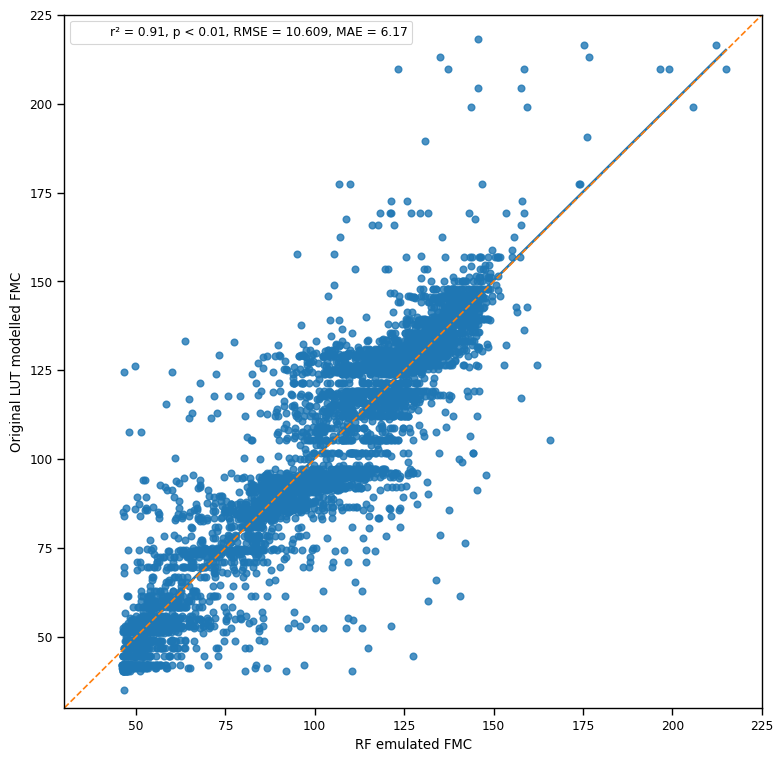

Only NDII and all bands :


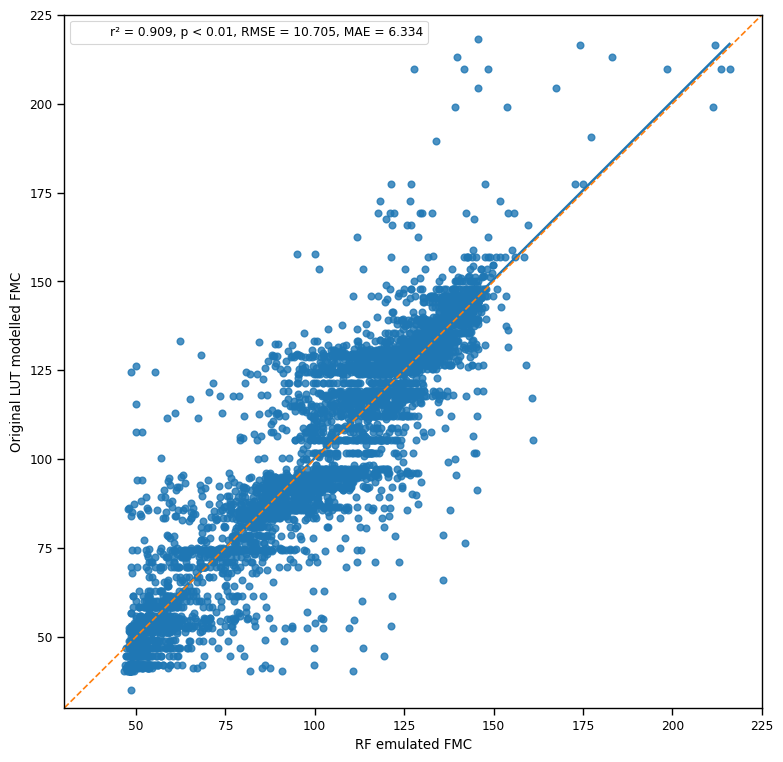

Only NDVI and all bands :


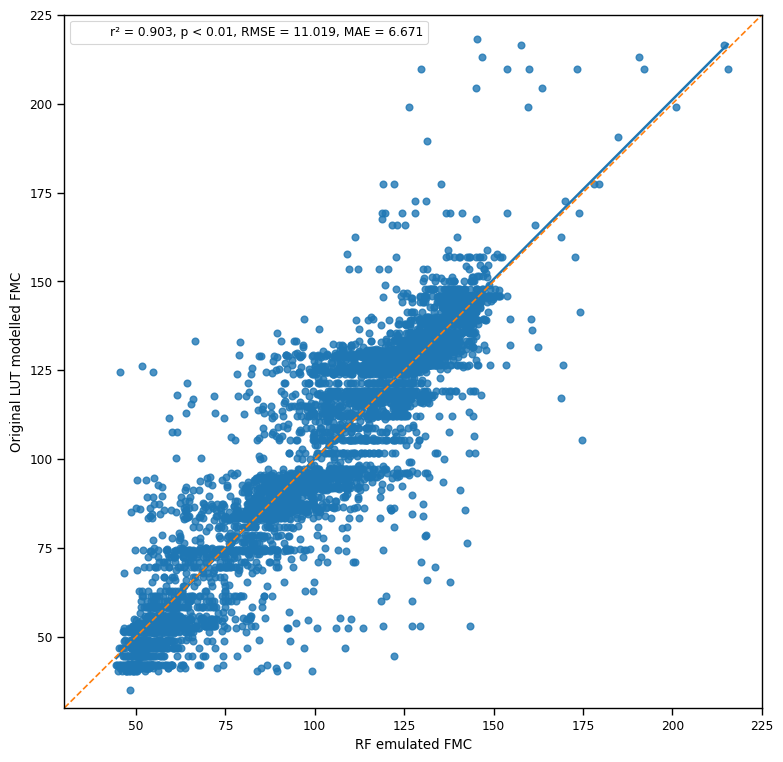

Only bands :


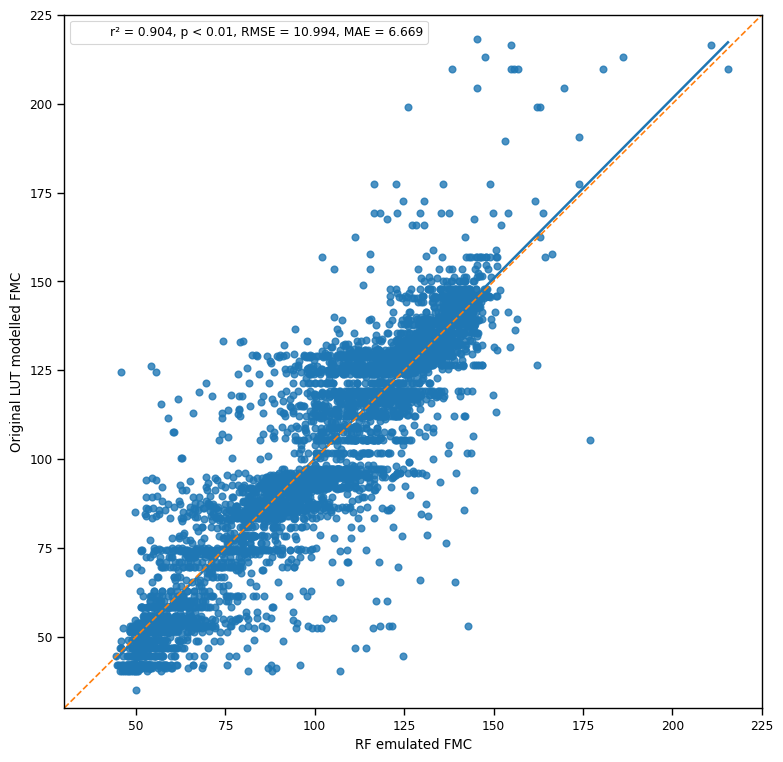

All indices and bands except red edges :


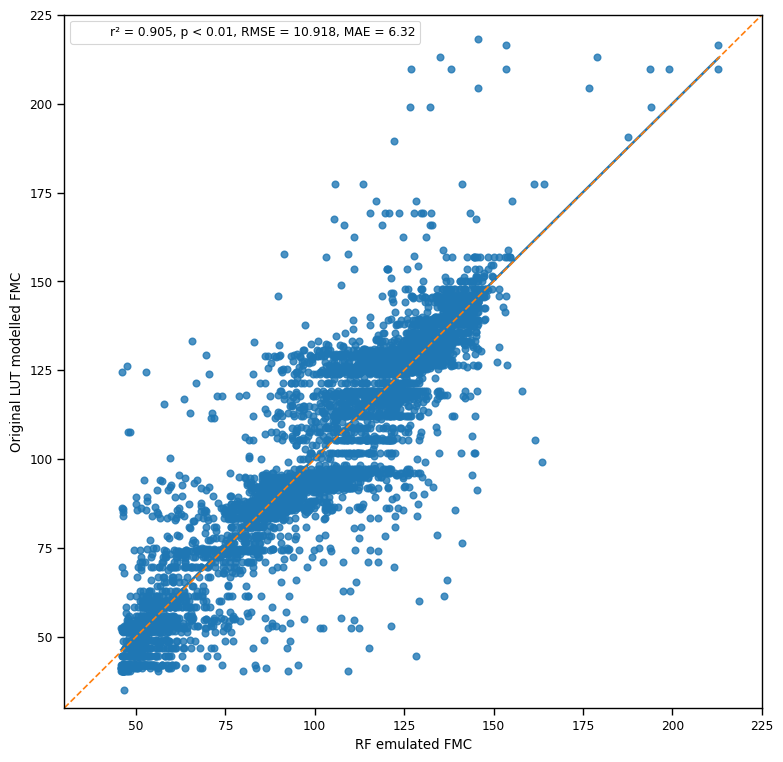

All indices and bands except green :


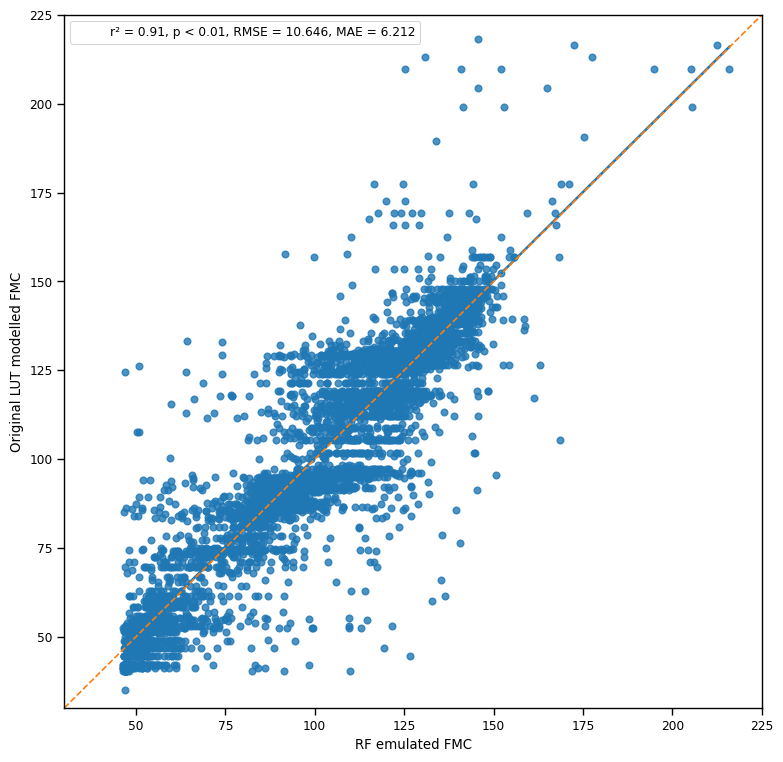

In [106]:
for variables in var.items():
    print(variables[0],':')
    rf = RandomForestRegressor(n_estimators=25, max_depth=10, n_jobs=8)
    # train, test = generate_train_datasets(veg_type)
    rf.fit(train[variables[1]], train['fmc'])
    y_hat = rf.predict(test[variables[1]])
    
    lims = (30,225)
    regplot_stats(data=pd.concat([test['fmc'].reset_index(drop=True),pd.Series(y_hat)],axis='columns',
                         ignore_index=True).rename(columns={0:'fmc',1:'fmc_pred'}),
                  x='fmc_pred', y='fmc',xlims=lims,ylims=lims,origin_line=True,
                  outfilep=f'/g/data/bz23/IvanK/emulator_fmc_s2/figs/fmc_emulator_{variables[0]}_replot_stats_paper.png',
                  x_axname='RF emulated FMC',y_axname='Original LUT modelled FMC');plt.show()

Best result above - using all reflectance bands (including red_edge), NDVI and NDII

### RF configuration R2 comparison

In [141]:
# predictors = ['nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']
combinations = []
cols=['n trees','Tree depth','r\u00b2','Fitting time','RMSE','MAE','Predicting time']
configs = pd.DataFrame(columns=cols)
for veg_type in [3]:#[0,1,2,3]:
    # print(f"------- Vegetation type: {veg_type_name[veg_type]} --------")
    for n_estimators in [10,25,50]:
        for max_depth in [5,10,25,50]:
            rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=8)
            # train, test = generate_train_datasets(veg_type)
            t0 = time.time()
            rf.fit(train[var['All indices and bands']], train['fmc'])
            t1 = time.time()
            score = rf.score(test[var['All indices and bands']], test['fmc'])
            t0_pred = time.time()
            y_hat = rf.predict(test[var['All indices and bands']])
            t1_pred = time.time()
            rmse = mean_squared_error(y_true=test['fmc'].values, y_pred=y_hat, squared=False)
            mae = mean_absolute_error(y_true=test['fmc'].values, y_pred=y_hat)
            
            results = pd.Series(data=np.array(
                [n_estimators,max_depth,score,(t1-t0),rmse,mae,(t1_pred-t0_pred)])).to_frame().T
            results.columns = cols
            configs = pd.concat([configs, results])
            # print(f"        Estimators: {n_estimators} -- Depth: {max_depth:02} -- R2: {score:.3f} -- Fitting time: {(t1-t0):.4f}")
            # combinations.append((n_estimators,max_depth))
configs.reset_index(drop=True,inplace=True)
configs

,n trees,Tree depth,r²,Fitting time,RMSE,MAE,Predicting time
0,10.0,5.0,0.880448,0.209382,12.253149,7.867933,0.008474
1,10.0,10.0,0.907167,0.336748,10.797395,6.267003,0.009321
2,10.0,25.0,0.910889,0.543055,10.578743,6.014531,0.017050
3,10.0,50.0,0.912013,0.511353,10.511823,5.950610,0.014198
4,25.0,5.0,0.879956,0.442270,12.278305,7.872667,0.014578
5,25.0,10.0,0.909250,0.784328,10.675568,6.238679,0.011849
6,25.0,25.0,0.915210,1.256248,10.319083,5.777159,0.021662
7,25.0,50.0,0.915429,1.261689,10.305756,5.758532,0.024721
8,50.0,5.0,0.881592,0.825987,12.194365,7.793341,0.018285
9,50.0,10.0,0.911292,1.508542,10.554802,6.149671,0.019023


### Run the optimal RF model and plot predictons

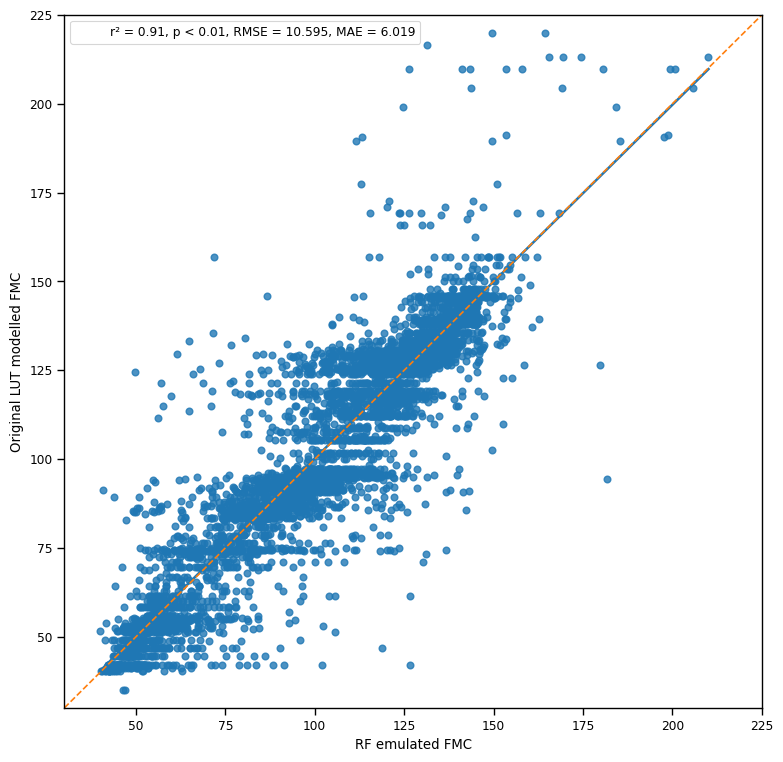

In [6]:
estimators = 25
max_depth = 25

### Test using NDVI, NDII, as well as reflectance bands (including the red edge bands)
variables = ['ndvi','ndii','nbart_blue','nbart_green','nbart_red','nbart_red_edge_1','nbart_red_edge_2',
             'nbart_red_edge_3','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']

for veg_type in [3]:#[0,1,2,3]:
    rf = RandomForestRegressor(n_estimators=estimators, max_depth=max_depth, n_jobs=8)
    # train, test = generate_train_datasets(veg_type)
    rf.fit(train[variables], train['fmc'])
    y_hat = rf.predict(test[variables])
    # axs[veg_type].scatter(y_hat, test['fmc'].values)
    # score = rf.score(test[variables], test['fmc'])
    # axs[veg_type].set_title(f"Vegetation type: {veg_type_name[veg_type]}. R2: {score:.2f}")
    # plt.scatter(y_hat, test['fmc'].values)
    score = r2_score(y_true=test['fmc'].values, y_pred=y_hat)
    rmse = mean_squared_error(y_true=test['fmc'].values, y_pred=y_hat, squared=False)
    mae = mean_absolute_error(y_true=test['fmc'].values, y_pred=y_hat)
    # axs[veg_type].set_title(f"Vegetation type: {veg_type_name[veg_type]}. R2: {score:.2f}")
    # plt.title(f"Vegetation type: {veg_type_name[veg_type]}. R2:{score:.2f}. RMSE:{rmse:.2f}, MAE:{mae:.2f}")
    
    lims = (30,225)
    regplot_stats(data=pd.concat([test['fmc'].reset_index(drop=True),pd.Series(y_hat)],axis='columns',
                         ignore_index=True).rename(columns={0:'fmc',1:'fmc_pred'}),
                  x='fmc_pred', y='fmc',xlims=lims,ylims=lims,origin_line=True,
                  outfilep='/g/data/bz23/IvanK/emulator_fmc_s2/figs/fmc_emulator_optimised_allbands_replot_stats_paper.png',
                  x_axname='RF emulated FMC',y_axname='Original LUT modelled FMC');plt.show()

#### Are there significant differences between the models of different RF parameters?

In [77]:
predictions = pd.DataFrame(columns=['Parameter set','predictions'])
for n_estimators in [10,25,50]:
    for max_depth in [5,10,25,50]:
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=8)
        rf.fit(train[var['All indices and bands']], train['fmc'])
        y_hat = rf.predict(test[var['All indices and bands']])
        output = pd.DataFrame({'predictions':y_hat})
        output['Parameter set'] = str(n_estimators)+'-'+str(max_depth)
        predictions = pd.concat([predictions,output])

In [80]:
summary = predictions.groupby('Parameter set')['predictions'].describe()
summary

,count,mean,std,min,25%,50%,75%,max
Parameter set,,,,,,,,
10-10,7499.0,105.584736,33.822305,44.583625,76.834297,115.005356,134.862266,215.188786
10-25,7499.0,105.499680,34.061603,36.803927,76.994134,114.508445,135.296879,209.551287
10-5,7499.0,105.551759,32.608086,51.749834,77.514980,112.874642,132.141821,182.823643
10-50,7499.0,105.582043,34.117211,36.344772,76.802960,114.519199,135.489550,210.461436
25-10,7499.0,105.547514,33.826570,44.247624,76.796202,114.865972,135.278449,206.510845
25-25,7499.0,105.436587,33.997169,39.573038,76.868139,113.989934,135.398745,208.141827
25-5,7499.0,105.580938,32.630390,52.098046,76.191038,113.207082,132.603417,185.107918
25-50,7499.0,105.453658,33.986234,39.459288,76.568203,114.137266,135.407124,210.540147
50-10,7499.0,105.546595,33.792250,44.350707,76.660429,114.500925,135.104107,208.514940


In [95]:
ttests = pd.DataFrame(columns=['Parameter set','T-statistic','p-value'])
pair_var = itertools.permutations(summary.index.tolist(),2)
for idx,(i,ii) in enumerate(pair_var):
    # print(i,'vs',ii)
    stat,p = stats.ttest_ind(predictions.loc[predictions['Parameter set']==i,'predictions'],
                            predictions.loc[predictions['Parameter set']==ii,'predictions'])
    # print(f'     T-statistic ={np.round(stat,4)}, p ={np.round(p,2)}')
    ttests = ttests.append(pd.DataFrame(data={'Parameter set':str(i)+' vs '+str(ii), 'T-statistic':stat, 'p-value':p},index=[idx]))

In [97]:
ttests.sort_values('p-value')

,Parameter set,T-statistic,p-value
115,50-5 vs 25-25,0.283792,0.776574
64,25-25 vs 50-5,-0.283792,0.776574
55,25-25 vs 10-10,-0.267522,0.789071
4,10-10 vs 25-25,0.267522,0.789071
71,25-5 vs 25-25,0.265273,0.790803
...,...,...,...
38,10-50 vs 25-5,0.002026,0.998384
92,50-10 vs 25-10,-0.001665,0.998672
51,25-10 vs 50-10,0.001665,0.998672
87,25-50 vs 50-50,-0.001038,0.999172


#### Are there significant differences between the models of different predictor variables?

In [34]:
# Using the same train/test set save the predictions between models of different variables, then compare
predictions = pd.DataFrame(columns=['Variable set','predictions'])
# train, test = generate_train_datasets(veg_type)
for variables in var.items():
    # print(variables[0],':')
    rf = RandomForestRegressor(n_estimators=25, max_depth=25, n_jobs=8)
    rf.fit(train[variables[1]], train['fmc'])
    y_hat = rf.predict(test[variables[1]])
    output = pd.DataFrame({'predictions':y_hat})
    output['Variable set'] = variables[0]
    predictions = pd.concat([predictions,output])

In [57]:
summary = predictions.groupby('Variable set')['predictions'].describe()
summary

,count,mean,std,min,25%,50%,75%,max
Variable set,,,,,,,,
All indices and bands,7499.0,105.281940,34.053023,41.378206,76.124138,113.892584,135.553811,210.556413
All indices and bands except green,7499.0,105.384617,34.018364,41.604990,76.301570,113.997565,135.815083,210.114655
All indices and bands except red edges,7499.0,105.342295,34.099065,41.072984,76.247756,113.955557,135.767954,213.882056
Only NDII and all bands,7499.0,105.347492,33.964137,41.279262,76.352716,113.455769,135.831283,214.280958
Only NDVI and all bands,7499.0,105.367823,33.549208,42.029021,76.569843,113.032759,135.339757,198.678208
Only bands,7499.0,105.379979,33.587415,41.594855,77.025015,113.372994,135.260142,209.275162


In [53]:
pair_var = itertools.permutations(predictions['Variable set'].unique().tolist(),2)
for i,ii in pair_var:
    print(i,'vs',ii)
    stat,p = stats.ttest_ind(predictions.loc[predictions['Variable set']==i,'predictions'],
                            predictions.loc[predictions['Variable set']==ii,'predictions'])
    print(f'     T-statistic ={np.round(stat,4)}, p ={np.round(p,2)}')

All indices and bands vs Only NDII and all bands
     T-statistic =-0.118, p =0.91
All indices and bands vs Only NDVI and all bands
     T-statistic =-0.1556, p =0.88
All indices and bands vs Only bands
     T-statistic =-0.1775, p =0.86
All indices and bands vs All indices and bands except red edges
     T-statistic =-0.1085, p =0.91
All indices and bands vs All indices and bands except green
     T-statistic =-0.1847, p =0.85
Only NDII and all bands vs All indices and bands
     T-statistic =0.118, p =0.91
Only NDII and all bands vs Only NDVI and all bands
     T-statistic =-0.0369, p =0.97
Only NDII and all bands vs Only bands
     T-statistic =-0.0589, p =0.95
Only NDII and all bands vs All indices and bands except red edges
     T-statistic =0.0094, p =0.99
Only NDII and all bands vs All indices and bands except green
     T-statistic =-0.0669, p =0.95
Only NDVI and all bands vs All indices and bands
     T-statistic =0.1556, p =0.88
Only NDVI and all bands vs Only NDII and all ba

#### Calculate performance of best model across 1000 runs

In [ ]:
estimators = 25
max_depth = 25
variables = ['ndvi','ndii','nbart_blue','nbart_green','nbart_red','nbart_red_edge_1','nbart_red_edge_2',
             'nbart_red_edge_3','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']
score_runs,rmse_runs,mae_runs = [],[],[]
for run in np.arange(100):
    for veg_type in [3]:#[0,1,2,3]:
        rf = RandomForestRegressor(n_estimators=estimators, max_depth=max_depth, n_jobs=8)
        # train, test = generate_train_datasets(veg_type)
        rf.fit(train[variables], train['fmc'])
        y_hat = rf.predict(test[variables])
        plt.scatter(y_hat, test['fmc'].values)
        score_runs.append(r2_score(y_true=test['fmc'].values, y_pred=y_hat))
        rmse_runs.append(mean_squared_error(y_true=test['fmc'].values, y_pred=y_hat, squared=False))
        mae_runs.append(mean_absolute_error(y_true=test['fmc'].values, y_pred=y_hat))
print(f'R2 mean:{np.mean(score_runs)}. RMSE mean:{np.mean(rmse_runs)}. MAE mean:{np.mean(mae_runs)}')

### FMC inference on satellite image

In [3]:
import datacube
dc = datacube.Datacube(app='sentinel_fmc')
import sys
sys.path.insert(1, 'dea-notebooks/Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb
import xarray as xr
import geopandas as gpd
import datetime
from scipy import stats
import seaborn as sns

In [26]:
# Get some reflectance data of interesting area
# Requires access to the DEA via Sandbox or NCI - https://docs.dea.ga.gov.au/setup/README.html

# Define centre coordinates of area
x,y = 1727155.709,-3850413.587
# Get grid corners
xmin, xmax, ymin, ymax = x - 5000, x + 5000, y - 5000, y + 5000
# Get reflectance data
# Query the datacube using the 'like' attribute of load_ard, to take the spatial and temporal resolution of the kti dataset
ds = load_ard(dc=dc, 
               products=['ga_s2am_ard_3','ga_s2bm_ard_3'],
               x=(xmin, xmax),
               y=(ymax, ymin),
               time=('2023-01', '2023-04'),
               output_crs='EPSG:3577',
               resolution=(-20, 20),
               measurements=variables[2:],
               group_by='solar_day', 
               dask_chunks = {'time':1},
               cloud_mask='fmask')
print('Data loaded.')

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying fmask pixel quality/cloud mask
Returning 9 time steps as a dask array
Data loaded.


In [27]:
# Prepare the reflectance data

ds['ndvi'] = ((ds.nbart_nir_1-ds.nbart_red)/(ds.nbart_nir_1+ds.nbart_red))
ds['ndii'] = ((ds.nbart_nir_1-ds.nbart_swir_2)/(ds.nbart_nir_1+ds.nbart_swir_2))
da = ds[variables].isel(time=0)
refl = da.to_array().values
nan_mask = np.isnan(refl) # nan values are not accepted by the RF model. So first they will be replaced with 0 (below), so that the model can run. Then this mask will be applied to restore the nan in the LFMC map
nan_mask_2d = np.sum(np.where(nan_mask,1,0), axis=0) # if 0, there were no nan values in any of the reflectance bands, if a pixel is > 0 then at least one of the bands in that position was nan
refl = np.where(nan_mask, 0, refl) # replace nan values with 0 so that the model can run
refl_rf = refl.reshape((len(variables),-1)).swapaxes(0,1)
refl_rf.shape

(250000, 12)

In [28]:
%time 

# Apply random forest model, predicting FMC
rf_fmc = rf.predict(refl_rf)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 20.3 µs


/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


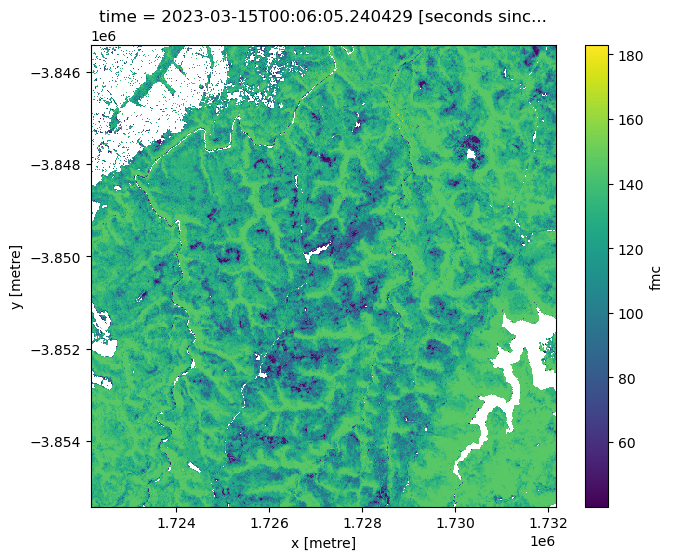

In [29]:
# Map FMC prediction
fmc = rf_fmc.reshape(refl.shape[1:])
np.where(nan_mask_2d>0, np.nan, fmc)
da['fmc'] = (['y','x'],fmc)
da = da.where(msk)
da.fmc.plot(figsize=(7.5,6));

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


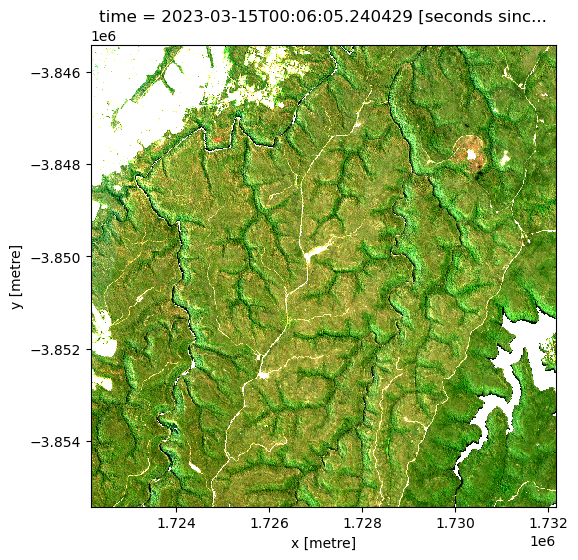

In [30]:
# Map the same area in false colour using reflectance data
rgb(da)

### Saving optimal model
 - First wrap model the sklearn_xarray implimentation of the sklearn RF library

In [1]:
import sklearn_xarray

In [40]:
rf_xr = sklearn_xarray.wrap(rf)

In [44]:
with open('/g/data/bz23/IvanK/emulator_fmc_s2/rf_xr_s2fmc_forest.pickle', 'wb') as handle:
    pickle.dump(rf_xr, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Feature Importance

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

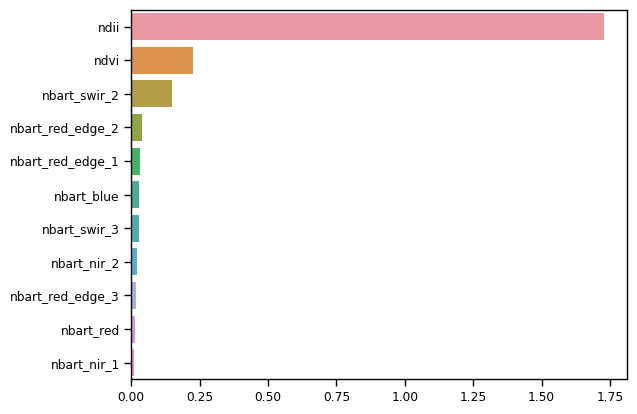

In [196]:
# Retrieve predictor importance from RF object and plot
result = permutation_importance(rf,train[variables[1]], train['fmc'])
data = pd.DataFrame(result.importances_mean,index=variables[1])
data = data.sort_values(0,ascending=False).T
sns.barplot(data,orient='h')

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


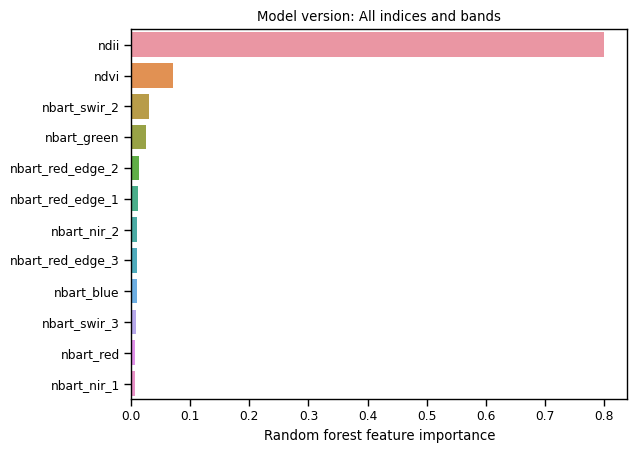

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


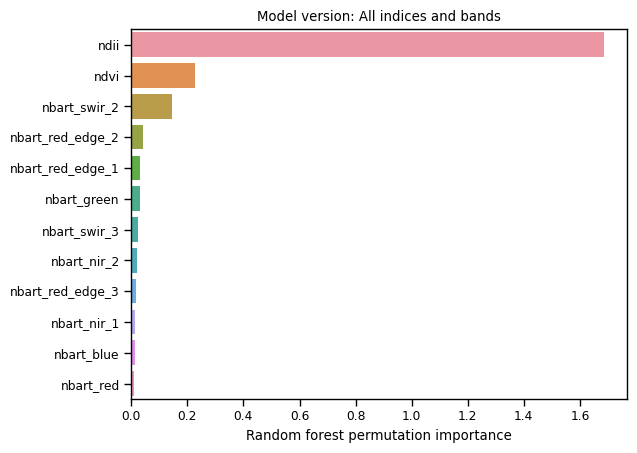

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


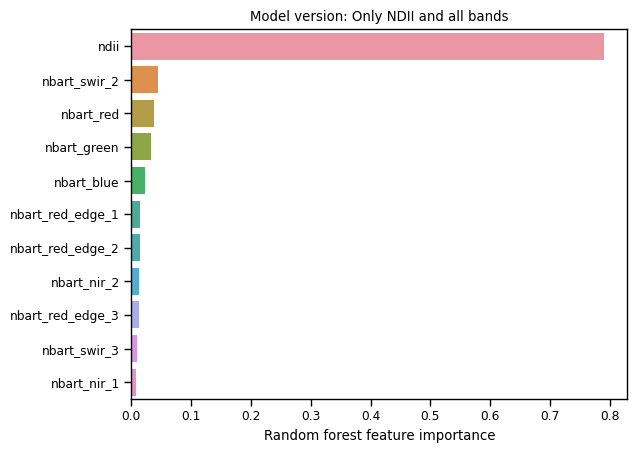

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


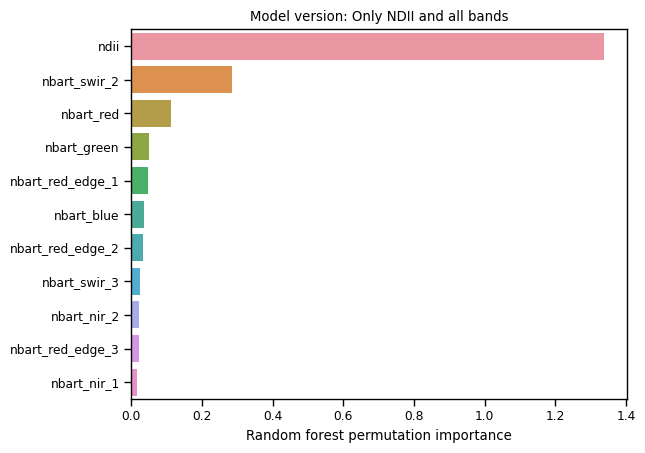

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


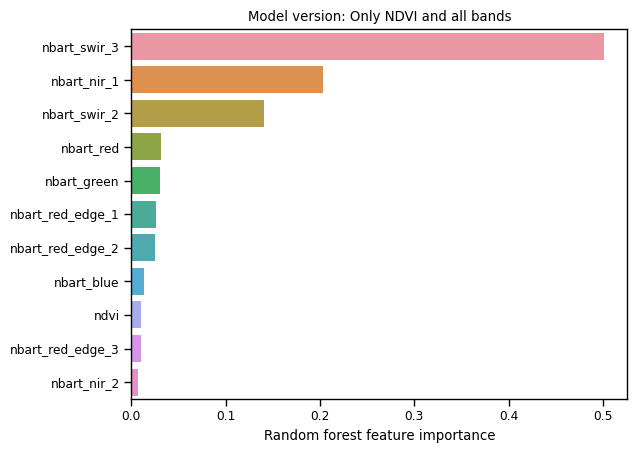

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


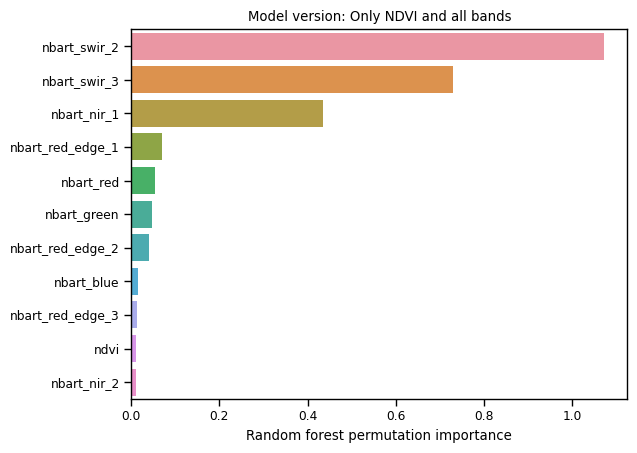

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


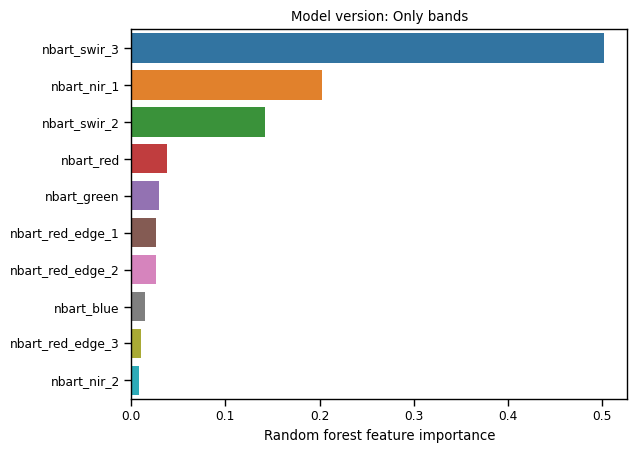

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


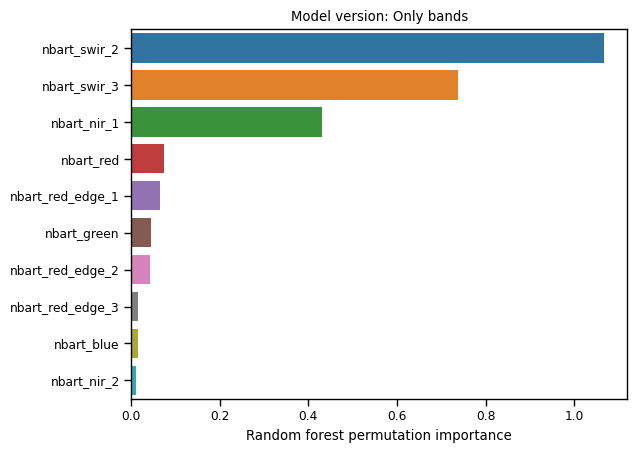

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


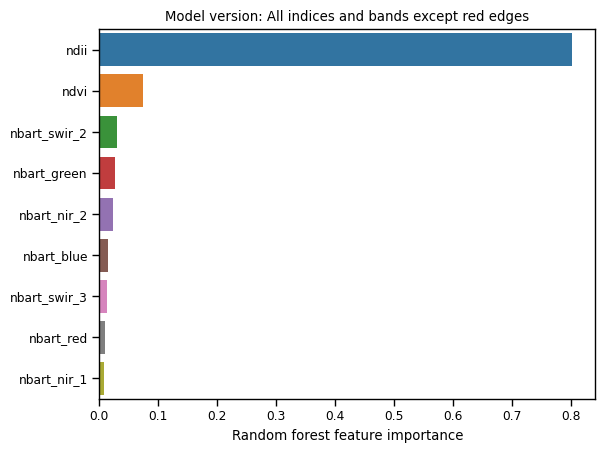

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


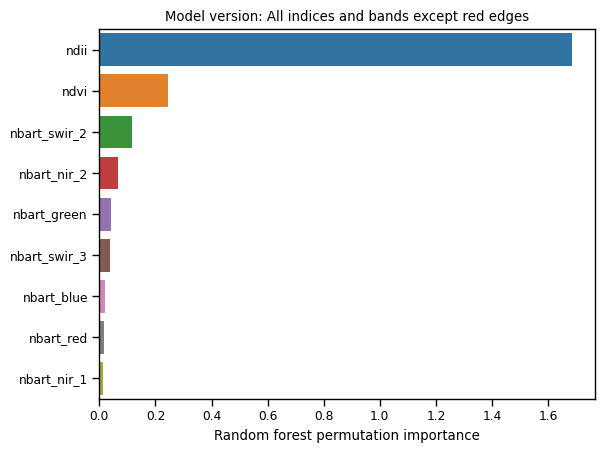

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


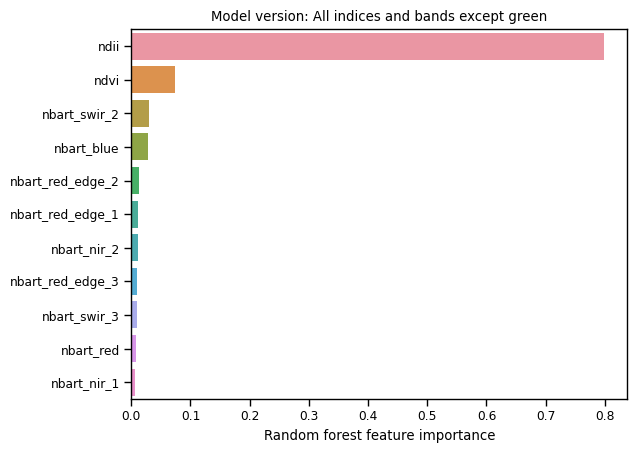

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


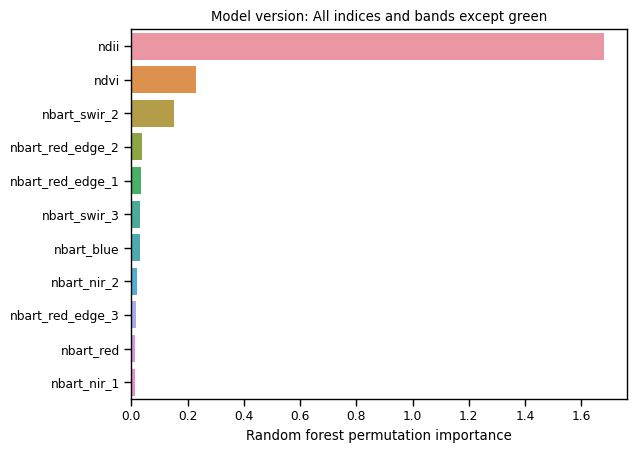

In [197]:
# For differenc combinations of predictrs, retrieve importance from RF object and plot
for variables in var.items():
    # print(variables[0],':')
    # Test feature importance for best model above
    # rf = RandomForestRegressor(n_estimators=25, max_depth=25, n_jobs=8)
    # train, test = generate_train_datasets(3)
    # predictors = ['ndvi','ndii','nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']
    rf.fit(train[variables[1]], train['fmc'])
    y_hat = rf.predict(test[variables[1]])
    score = r2_score(y_true=test['fmc'].values, y_pred=y_hat)
    rmse = mean_squared_error(y_true=test['fmc'].values, y_pred=y_hat, squared=False)
    mae = mean_absolute_error(y_true=test['fmc'].values, y_pred=y_hat)
    
    # plt.title(f"Vegetation type: {veg_type_name[veg_type]}. R2:{score:.2f}. RMSE:{rmse:.2f}, MAE:{mae:.2f}") 
    # plt.barh(variables[1], rf.feature_importances_);plt.show()
    
    data = pd.Series(rf.feature_importances_,index=variables[1]).to_frame()
    data = data.sort_values(0,ascending=False).T
    sns.barplot(data=data,orient='h');plt.title(f'Model version: {variables[0]}');plt.xlabel('Random forest feature importance')
    plt.savefig(f'/g/data/bz23/IvanK/emulator_fmc_s2/figs/fmc_emulator_predictors_{variables[0]}_barplot_paper.png',
               bbox_inches='tight')
    plt.show()
    
    result = permutation_importance(rf,train[variables[1]], train['fmc'])
    data = pd.DataFrame(result.importances_mean,index=variables[1])
    data = data.sort_values(0,ascending=False).T
    sns.barplot(data=data,orient='h');plt.title(f'Model version: {variables[0]}');plt.xlabel('Random forest permutation importance')
    plt.savefig(f'/g/data/bz23/IvanK/emulator_fmc_s2/figs/fmc_emulator_predictors_permImporta_{variables[0]}_barplot_paper.png',
               bbox_inches='tight')
    plt.show()

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


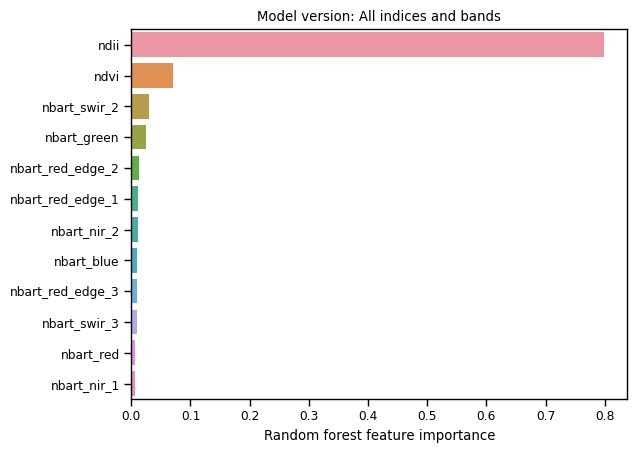

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


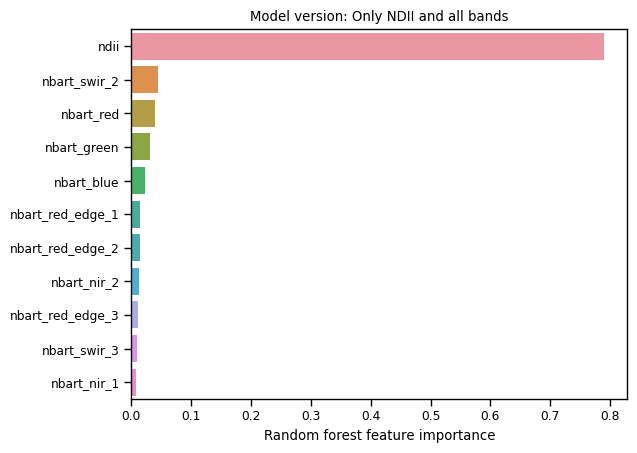

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


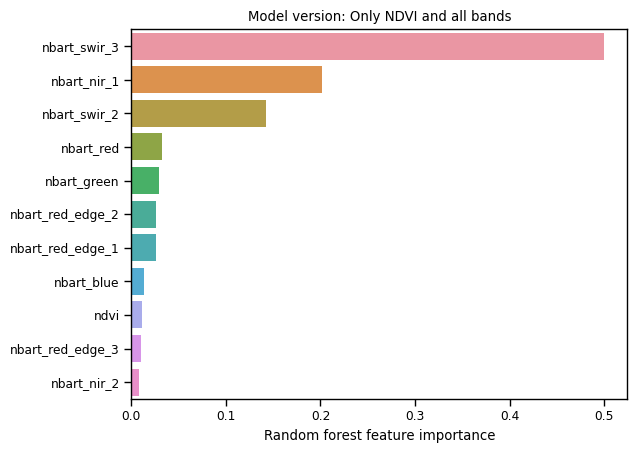

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


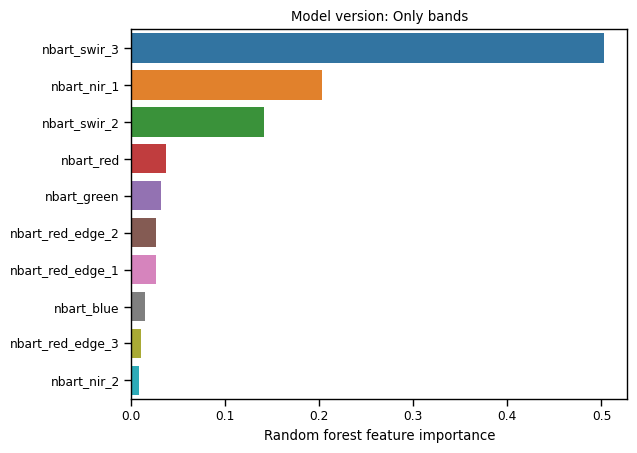

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


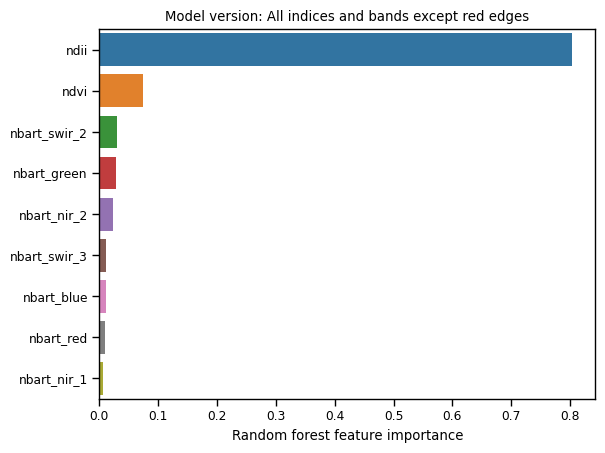

/g/data/v10/public/modules/dea-env/20221025/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


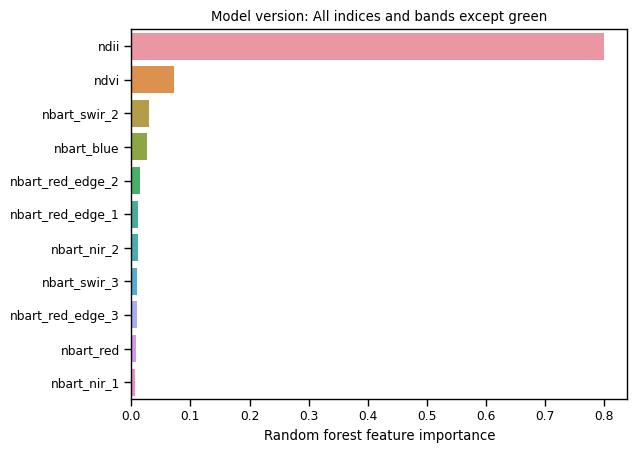

In [158]:
for variables in var.items():
    # print(variables[0],':')
    # Test feature importance for best model above
    # rf = RandomForestRegressor(n_estimators=25, max_depth=25, n_jobs=8)
    # train, test = generate_train_datasets(3)
    # predictors = ['ndvi','ndii','nbart_blue','nbart_green','nbart_red','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']
    rf.fit(train[variables[1]], train['fmc'])
    y_hat = rf.predict(test[variables[1]])
    score = r2_score(y_true=test['fmc'].values, y_pred=y_hat)
    rmse = mean_squared_error(y_true=test['fmc'].values, y_pred=y_hat, squared=False)
    mae = mean_absolute_error(y_true=test['fmc'].values, y_pred=y_hat)
    
    # plt.title(f"Vegetation type: {veg_type_name[veg_type]}. R2:{score:.2f}. RMSE:{rmse:.2f}, MAE:{mae:.2f}") 
    # plt.barh(variables[1], rf.feature_importances_);plt.show()
    
    data = pd.Series(rf.feature_importances_,index=variables[1]).to_frame()
    # data.index = variables[1]
    data = data.sort_values(0,ascending=False).T
    sns.barplot(data=data,orient='h');plt.title(f'Model version: {variables[0]}');plt.xlabel('Random forest feature importance')
    plt.savefig(f'/g/data/bz23/IvanK/emulator_fmc_s2/figs/fmc_emulator_predictors_{variables[0]}_barplot_paper.png',
               bbox_inches='tight')
    plt.show()